In [36]:
#STOCK SCREENING
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from io import StringIO
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(url).text
table = pd.read_html(StringIO(response))
sp500_tickers = table[0]['Symbol'].tolist()
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

def filter_positive_growth(stock):
    ticker = yf.Ticker(stock)
    
    # Fetching the income statement and cash flow
    income_stmt = ticker.financials
    cf = ticker.cashflow
    
    try:
        # Get the Free Cash Flow, Pretax Income, and Tax Provision
        free_cash_flow = cf.loc["Free Cash Flow"].dropna().values
        pre_tax_income = income_stmt.loc["Pretax Income"].dropna().values
        tax_provision = income_stmt.loc["Tax Provision"].dropna().values
        
        # Check if Free Cash Flow is growing over the years
        #if len(free_cash_flow) < 2:
            #return False  # Not enough data to determine growth
        
        # Check if Free Cash Flow is growing
        free_cash_flow_growth = np.all(np.diff(free_cash_flow) > 0)
        
        # Check if Pretax Income and Tax Provision are always positive
        positive_pretax_income = np.all(pre_tax_income > 0)
        positive_tax_provision = np.all(tax_provision > 0)
        
        # Return True if all conditions are met
        return free_cash_flow_growth and positive_pretax_income and positive_tax_provision

    except KeyError:
        return False

# Filter tickers based on the given criteria
filtered_tickers = []
for stock in sp500_tickers:  
    if filter_positive_growth(stock):
        filtered_tickers.append(stock)

# Print the filtered tickers
print(filtered_tickers)


KeyboardInterrupt: 

[*********************100%***********************]  1 of 1 completed


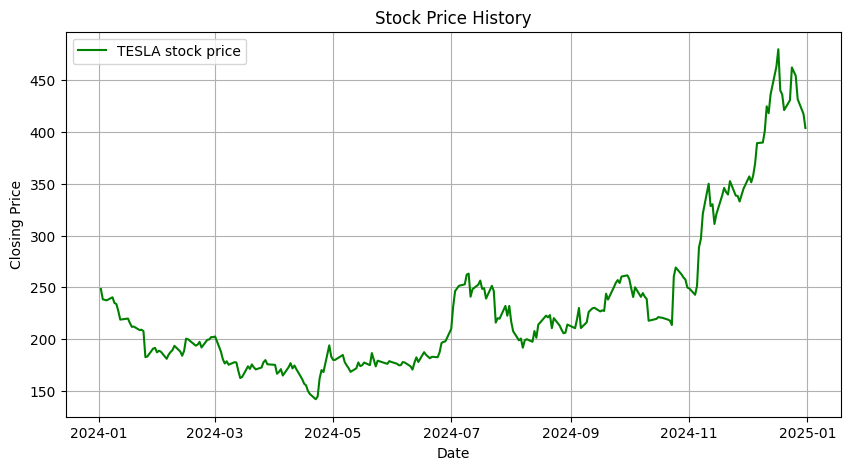

In [40]:
#OPTIONAL
import pandas as pd 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import yfinance as yf
stock_price = yf.download('TSLA', start='2024-01-01', end="2025-01-01")
#print(stock_price)
#STEP 2: create stock price's history chart to check the trend. 
plt.figure(figsize=(10, 5)) # size
#show plot general: stock_price.index: date X axis, stock_price['Close': Y axix ( close la 1 muc o yfinance)
plt.plot(stock_price.index, stock_price['Close'], label='TESLA stock price',color='green') 
#Customize the chart
plt.title('Stock Price History')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
#Fetching cashflow
ticker = yf.Ticker(stock)
cash_flow= ticker.cashflow
cash_flow = cash_flow.drop(" 2020-12-31", axis = 1)
fcf = cash_flow.loc["Free Cash Flow"].values 
print(cash_flow)
#print(fcf)

#Fetching income statement
income_statement = ticker.income_stmt
income_statement= income_statement.drop(" 2020-12-31", axis = 1)
tp = income_statement.loc["Tax Provision"].values

#Calculate free cash flow to firm
free_cash_flow_firm = (cash_flow.loc['Free Cash Flow'].astype(int) \
                    + (income_statement.loc['Interest Expense'].astype(int) \
                       * (1 - income_statement.loc['Tax Provision'].astype(int) \
                          / income_statement.loc['Pretax Income'].astype(int)))).astype(int)
free_cash_flow_firm_df = free_cash_flow_firm.to_frame().transpose()
print(free_cash_flow_firm_df)



                                         2024-12-31    2023-12-31  \
Free Cash Flow                         1550000000.0  1714000000.0   
Repayment Of Debt                     -1418000000.0  -855000000.0   
Issuance Of Debt                        995000000.0  2006000000.0   
Capital Expenditure                    -401000000.0  -387000000.0   
Interest Paid Supplemental Data         550000000.0   570000000.0   
...                                             ...           ...   
Amortization Of Intangibles             312000000.0   362000000.0   
Depreciation                            268000000.0   248000000.0   
Operating Gains Losses                 -689000000.0  -689000000.0   
Pension And Employee Benefit Expense   -689000000.0  -689000000.0   
Net Income From Continuing Operations  2050000000.0  1618000000.0   

                                         2022-12-31    2021-12-31  
Free Cash Flow                         1803000000.0  1359000000.0  
Repayment Of Debt                  

In [25]:
#Combine to creat a present table to show on Excel
income_statement_df = income_statement.loc[["Interest Expense","Tax Provision","Pretax Income"],:]
free_cf = cash_flow.loc[["Free Cash Flow"],:]
fcff_df=pd.concat([free_cf,income_statement_df])
#print(fcff_df)

fcff= pd.concat([fcff_df,free_cash_flow_firm_df],ignore_index=False) #show headers for rows : ignore index FALSE, otherwise  TRUE
fcff = fcff.iloc[:, ::-1] #reverses the order of columns
print(fcff)

                     2021-12-31     2022-12-31     2023-12-31     2024-12-31
Free Cash Flow    12347000000.0  13044000000.0  13721000000.0  14598000000.0
Interest Expense    920000000.0    938000000.0   1045000000.0   1037000000.0
Tax Provision      1642000000.0   1062000000.0    560000000.0   1178000000.0
Pretax Income      8518000000.0   6364000000.0   2162000000.0   5622000000.0
0                   13089653204    13825470144    14495324699    15417713269


In [26]:
# CALCULATE THA CAGR: 
#The table importing in yfinance shows earliest time at the last column [-1], latest at the first colum [0]
earliest_free_cash_flow_firm = float(free_cash_flow_firm_df.iloc[0,len(free_cash_flow_firm_df.columns)-1]) 
latest_free_cash_flow_firm = float(free_cash_flow_firm_df.iloc[0,0])
free_cash_flow_firm_CAGR = (latest_free_cash_flow_firm/earliest_free_cash_flow_firm)\
                            **(float(1/(len(free_cash_flow_firm_df.columns))))-1
#print(earliest_free_cash_flow_firm)
#print(float(len(free_cash_flow_firm_df.columns)))
#print(latest_free_cash_flow_firm)
free_cash_flow_firm_CAGR

0.041772660666786754

In [43]:
#FORECAST FCFF based on the CAGR: 1 stage model
forecast_free_cash_flow_firm_df = pd.DataFrame(columns=['Year ' + str(i) for i in range(1,6)])
free_cash_flow_firm_forecast_lst = []
for i in range(1,6):
    free_cash_flow_firm_forecast = latest_free_cash_flow_firm*(1+free_cash_flow_firm_CAGR)**i
    free_cash_flow_firm_forecast_lst.append(int(free_cash_flow_firm_forecast))
forecast_free_cash_flow_firm_df.loc[0] = free_cash_flow_firm_forecast_lst
print(forecast_free_cash_flow_firm_df)

#add this to the previous fcff table:
combinedforecast_df = pd.concat([fcff,forecast_free_cash_flow_firm_df], axis = 1)
print(combinedforecast_df)

        Year 1       Year 2       Year 3       Year 4       Year 5
0  16061752173  16732694296  17431663457  18159830420  18918414854
                 2021-12-31 00:00:00 2022-12-31 00:00:00 2023-12-31 00:00:00  \
Free Cash Flow         12347000000.0       13044000000.0       13721000000.0   
Interest Expense         920000000.0         938000000.0        1045000000.0   
Tax Provision           1642000000.0        1062000000.0         560000000.0   
Pretax Income           8518000000.0        6364000000.0        2162000000.0   
0                        13089653204         13825470144         14495324699   

                 2024-12-31 00:00:00        Year 1        Year 2  \
Free Cash Flow         14598000000.0           NaN           NaN   
Interest Expense        1037000000.0           NaN           NaN   
Tax Provision           1178000000.0           NaN           NaN   
Pretax Income           5622000000.0           NaN           NaN   
0                        15417713269  1.60617

In [28]:
#Calulate cost of equity: We r using 10 year US treasury yield as the risk-free rate: yfinance provided less of other countries

#RISK FREE RATE
import yfinance as yf
risk_free_rate = yf.Ticker("^TNX").history(period="1d")["Close"].iloc[-1]/100
print(risk_free_rate)

#BETA
ticker = yf.Ticker('MET')
info = ticker.info
# Get the beta value
beta = info.get('beta')
print(beta)

#MARKET RATE: SP 500 ANNUALIZE 10 YEAR
#(Ending Value / Starting Value) ^ (1 / number of years) - 1

import numpy as np
import pandas as pd
ticker = "^GSPC"
data = yf.download(ticker, period="10y", interval="1d")
starting_price = data["Close"].iloc[0]
ending_price = data["Close"].iloc[-1]
years = (data.index[-1] - data.index[0]).days / 365.25
market_rate = ((ending_price / starting_price) ** (1 / years) - 1)
print(market_rate)

# Cost of Equity: CAPM
cost_of_equity = risk_free_rate + beta*(market_rate-risk_free_rate)
cost_of_equity_df = float(cost_of_equity)
print(cost_of_equity_df)


0.04288000106811524


[*********************100%***********************]  1 of 1 completed

1.03
Ticker
^GSPC    0.104322
dtype: float64
0.10616486889942522



C:\Users\User\AppData\Local\Temp\ipykernel_15640\4005345828.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cost_of_equity_df = float(cost_of_equity)


In [29]:
# COST OF DEBT: CORP DEFAULT + RF RATE + country defualt spread ( NYU Professor)
#Determine the corp default rate based on the EBIT/interest expense
#: Mustbe value in the latest year

interest_expense = income_statement.loc['Interest Expense']
interest_expense_df = interest_expense.to_frame().transpose()
interest_expense_str = interest_expense_df.values[0][0]
interest_expense_int = int(interest_expense_str)
print (interest_expense_int)

EBIT = income_statement.loc['EBIT']
EBIT_df = EBIT.to_frame().transpose()
EBIT_str = EBIT_df.values[0][0]
EBIT_int = int(EBIT_str)
interest_coverage_ratio = EBIT_int/interest_expense_int
print(interest_coverage_ratio)

#CORP DEFAULT SPREAD FOR LARGE FINANCIAL FIRM (INSURANCE, BANKS, CREDIT UNION,..)
#OPTIONAL: faster if look at the table
def get_credit_rating(interest_coverage_ratio):
    if interest_coverage_ratio <= 0.049999:
        return {"Rating": "D2/D", "Spread": "19.00%"}
    elif 0.05 <= interest_coverage_ratio <= 0.099999:
        return {"Rating": "C2/C", "Spread": "15.50%"}
    elif 0.1 <= interest_coverage_ratio <= 0.199999:
        return {"Rating": "Ca2/CC", "Spread": "10.10%"}
    elif 0.2 <= interest_coverage_ratio <= 0.299999:
        return {"Rating": "Caa/CCC", "Spread": "7.28%"}
    elif 0.3 <= interest_coverage_ratio <= 0.399999:
        return {"Rating": "B3/B-", "Spread": "4.42%"}
    elif 0.4 <= interest_coverage_ratio <= 0.499999:
        return {"Rating": "B2/B", "Spread": "3.00%"}
    elif 0.5 <= interest_coverage_ratio <= 0.599999:
        return {"Rating": "B1/B+", "Spread": "2.61%"}
    elif 0.6 <= interest_coverage_ratio <= 0.749999:
        return {"Rating": "Ba2/BB", "Spread": "1.83%"}
    elif 0.75 <= interest_coverage_ratio <= 0.899999:
        return {"Rating": "Ba1/BB+", "Spread": "1.55%"}
    elif 0.9 <= interest_coverage_ratio <= 1.199999:
        return {"Rating": "Ba2/BBB", "Spread": "1.20%"}
    elif 1.2 <= interest_coverage_ratio <= 1.49999:
        return {"Rating": "A3/A-", "Spread": "0.95%"}
    elif 1.5 <= interest_coverage_ratio <= 1.99999:
        return {"Rating": "A2/A", "Spread": "0.85%"}
    elif 2 <= interest_coverage_ratio <= 2.49999:
        return {"Rating": "A1/A+", "Spread": "0.77%"}
    elif 2.5 <= interest_coverage_ratio <= 2.99999:
        return {"Rating": "Aa2/AA", "Spread": "0.60%"}
    else:
        return {"Rating": "Aaa/AAA", "Spread": "0.45%"}
rating_info = get_credit_rating(interest_coverage_ratio)
print(rating_info)
spread = float(rating_info["Spread"].strip('%'))  # GET ONLY the spread

#Cost of debt:
cost_of_debt = risk_free_rate + spread/100
print(cost_of_debt)


1037000000
6.421407907425265
{'Rating': 'Aaa/AAA', 'Spread': '0.45%'}
0.04738000106811524


In [51]:
#Determine the weight of Equity and weight of Debt + WACC calculation
#Weight of Equity: latest market capitalization
import yfinance as yf
stock = "MET"
ticker = yf.Ticker(stock)
market_cap = ticker.info['marketCap']
#print(market_cap)

# Total Debt: Look at the company fair value estimated:
market_value_debt = 14498000 + 425000
#print(market_value_debt)

# Effective Tax Rate
effective_tax_rate = income_statement.loc['Tax Provision'].astype(int) \
                    / income_statement.loc['Pretax Income'].astype(int)
avg_effective_tax_rate = sum(effective_tax_rate) / len(effective_tax_rate)
#print(effective_tax_rate)
#print(avg_effective_tax_rate)

#WACC CALCULATION
company_value = market_value_debt+ market_cap
WACC = ((market_cap/company_value) * cost_of_equity) \
        + ((market_value_debt/company_value) * (cost_of_debt * (1-avg_effective_tax_rate)))
WACC_df = float(WACC)
print(WACC_df)

0.10614530661665793


C:\Users\User\AppData\Local\Temp\ipykernel_15640\1402690095.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  WACC_df = float(WACC)


In [33]:
#Presennt WACC components onto Excel:
equity_risk_premium = float(market_rate - risk_free_rate)
after_tax_cod = avg_effective_tax_rate * cost_of_debt
after_tax_cod = float(after_tax_cod)
target_DE = market_value_debt/market_cap
target_DE = float(target_DE)
debt_tren_value = float(market_value_debt/ company_value)
equity_tren_value = float(market_cap/ company_value )

#WACC COMPONENT table: 
import pandas as pd
data = {
    "Cost of Equity": [""],
    "Risk Free Rate": [risk_free_rate],
    "Equity Risk Premium": [equity_risk_premium],
    "Beta": [beta],
    "CAPM": [cost_of_equity_df],
    "Cost of Debt": [""],
    "Pre_tax cost of Debt": [cost_of_debt],
    "Tax Rate": [avg_effective_tax_rate],
    "After-tax cost of debt": [after_tax_cod],
    "":[""], #CACH DONG
    "Target market D/E": [target_DE],
    "Weight of Debt": [debt_tren_value],
    "Weight of Equity": [equity_tren_value],
    "WACC": [WACC_df],
}

combinedWACC_df = pd.DataFrame(data, index=["Values"]).T
print(combinedWACC_df)


                          Values
Cost of Equity                  
Risk Free Rate           0.04288
Equity Risk Premium     0.061442
Beta                        1.03
CAPM                    0.106165
Cost of Debt                    
Pre_tax cost of Debt     0.04738
Tax Rate                0.207049
After-tax cost of debt   0.00981
                                
Target market D/E       0.000279
Weight of Debt          0.000279
Weight of Equity        0.999721
WACC                    0.106146


C:\Users\User\AppData\Local\Temp\ipykernel_15640\720779674.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  equity_risk_premium = float(market_rate - risk_free_rate)


In [49]:
#DCF MODEL

#Enterprise value
discounted_FCFF_lst = []
for year in range(0, 5):
    discounted_FCFF = forecast_free_cash_flow_firm_df.iloc[0, year]/(WACC + 1)** (year+1)
    discounted_FCFF_lst.append(int(discounted_FCFF.iloc[0]))
enterprise_value = sum(discounted_FCFF_lst)
print(f"Enterprise value: {enterprise_value}")

#Equity value = Enterprise + cash - debt
import yfinance as yf
stock = "MET"
ticker = yf.Ticker(stock)
balance_sheet= ticker.balance_sheet
#print(balance_sheet)
cash = balance_sheet.loc['Cash And Cash Equivalents']
cash_df = cash.to_frame().transpose()
cash_str = cash_df.values[0][0]
cash_int = int(cash_str)

equity_value = enterprise_value + cash_int - market_value_debt
print(f"Equity value: {equity_value}")

#SHARE OUTSTANDING: latest year: issued shares - treasury share
share_issued = balance_sheet.loc['Share Issued']
share_issued_df = share_issued.to_frame().transpose()
share_issued_str = share_issued_df.values[0][0]
share_issued_int = int(share_issued_str)

treasury_shares = balance_sheet.loc['Treasury Shares Number']
treasury_shares_df = treasury_shares.to_frame().transpose()
treasury_shares_str = treasury_shares_df.values[0][0]
treasury_shares_int = int(treasury_shares_str)

share_outstanding = share_issued_int - treasury_shares_int
print(f"Share outstanding: {share_outstanding}")

#STOCK VALUE
stock_price = equity_value / share_outstanding
print(f"stock price: {stock_price}")

Enterprise value: 64629658302
Equity value: 84682735302
Share outstanding: 689211065
stock price: 122.86908844390071


In [35]:
#PRESENT ALL ONTO AN EXISTING EXCEL WORKBOOK:
import pandas as pd
from openpyxl import load_workbook
file_path= r"C:\Users\User\Desktop/DCF.xlsx"
with pd.ExcelWriter(file_path, mode='a', engine="openpyxl", if_sheet_exists='overlay') as writer:
   balance_sheet.to_excel(writer, sheet_name='balance_sheet')
   income_statement.to_excel(writer, sheet_name='income_statement') 
   cash_flow.to_excel(writer, sheet_name='cash_flow')
   combinedforecast_df.to_excel(writer, sheet_name='DCF')
   combinedWACC_df.to_excel(writer, sheet_name='WACC')
                      